This is based on the tutorial Simoni Thomas: 
https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Doom/Deep%20Q%20learning%20with%20Doom.ipynb

In [1]:
import numpy as np
import vizdoom
import matplotlib.pyplot as plt
import random
import time
from skimage import transform
from collections import deque

In [9]:
image_size = 84
def preprocess_frame(img):
    x = np.mean(img, -1)
    x = x / 255.
    x = x[30:-10,30:-30]
    x = transform.resize(x, [image_size, image_size])
    return x

In [34]:
class Env():
    def __init__(self):
        self.game = vizdoom.DoomGame()
        # Load the correct configuration
        self.game.load_config("basic.cfg")
        # Load the correct scenario (in our case basic scenario)
        self.game.set_doom_scenario_path("basic.wad")
        self.game.init()
        # Here our possible actions
        left = [1, 0, 0]
        right = [0, 1, 0]
        shoot = [0, 0, 1]
        self.possible_actions = [left, right, shoot]
    
    def get_state(self):
        state = self.game.get_state()
        img = state.screen_buffer
        img = np.moveaxis(img, 0, -1)
        return preprocess_frame(img)
    
    def step(self, action):
        reward = self.game.make_action(action)
        return reward
    
    def is_episode_finished(self):
        return self.game.is_episode_finished()
    
    def new_episode(self):
        self.game.new_episode()
        
    def close(self):
        self.game.close()

c:\users\stig\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\stig\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


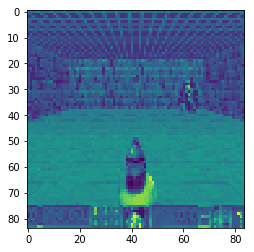

In [35]:
env = Env()
env.step([1, 0, 0])
img = env.get_state()
plt.imshow(img)
env.new_episode()

In [36]:
total_episodes = 500
memory_size = 1000000

In [37]:
class FrameStacker():
    def __init__(self, maxlen=4):
        self.maxlen = maxlen
        self.reset()
    
    def reset(self):
        self.frames = deque([np.zeros((image_size, image_size)) for i in range(self.maxlen)], self.maxlen)
        
    def stack(self, frame):
        self.frames.append(frame)
        return np.array(list(self.frames))

In [38]:
frame_stacker = FrameStacker()

In [39]:
frame_stacker.stack(np.random.randn(84, 84)).shape

(4, 84, 84)

In [110]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
    
    def add(self, experience_sample):
        self.buffer.append(experience_sample)
    
    def sample(self, num_samples):
        idx = np.random.choice(np.arange(len(self.buffer)), num_samples, replace=False)
        b = np.array(list(self.buffer)) #not efficient to do this each time
        return b[idx]

In [41]:
def random_action_selector():
    num_actions = len(env.possible_actions)
    action_id = np.random.choice(range(num_actions))
    return env.possible_actions[action_id]

In [119]:
class GamePlayer():
    def __init__(self, env, buffer, action_selector):
        self.env = env
        self.buffer = buffer
        self.action_selector = action_selector
        self.frame_stacker = FrameStacker()
    
    def play(self, num_steps):
        i = 0
        self.env.new_episode()
        state = self.frame_stacker.stack(self.env.get_state())
        while i < num_steps:
            i+=1
            action = self.action_selector()
            reward = self.env.step(action)
            finished = self.env.is_episode_finished()
            if finished:
                next_state = np.zeros(state.shape)
                self.buffer.add((state, action, reward, next_state, finished))
                self.env.new_episode()
                state = self.env.get_state()
            else:
                next_state = self.frame_stacker.stack(self.env.get_state())
                self.buffer.add((state, action, reward, next_state, finished))
                state = next_state

In [120]:
buffer = ReplayBuffer(memory_size)
player = GamePlayer(env, buffer, random_action_selector)
player.play(64)

c:\users\stig\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\stig\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1, 5)
(5,)
(4, 84, 84)


TypeError: Invalid dimensions for image data

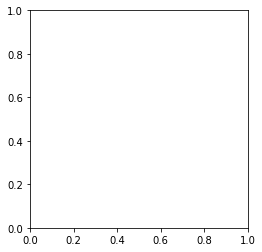

In [121]:
s = buffer.sample(1)
print(s.shape)
print(s[0].shape)
print(s[0][0].shape)
plt.imshow(s[0][0])